# **Task 2 - Custom Loss**
**Vision Transformer (ViT) Baseline**

**Authors:** Iris Vukovic & Olmo Gordon Rodriguez

---

## Downloading the APPA-REAL dataset
In this case, we are using the full dataset (not its reduced version)

In [ ]:
from zipfile import ZipFile

# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2025/appa-real-dataset_v2.zip

with ZipFile('appa-real-dataset_v2.zip','r') as zip_ref:
   zip_ref.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm appa-real-dataset_v2.zip

--2025-03-26 10:41:16--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2025/appa-real-dataset_v2.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129412950 (123M) [application/zip]
Saving to: ‘appa-real-dataset_v2.zip’

appa-real-dataset_v 100%[===================>] 123.42M  1.61MB/s    in 44s     

2025-03-26 10:42:01 (2.80 MB/s) - ‘appa-real-dataset_v2.zip’ saved [129412950/129412950]

Data decompressed successfully


## Check pytorch version
 - This notebook was successfully tested on version = 2.5.1+cu124

In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
# installing torchinfo to print model summary
!pip install torchinfo

## Import required libraries

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from PIL import Image
from timm import create_model
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm import tqdm

# Defining the data loader class
In this example, metadata information is loaded but not used. Future implementations can take benefit of it.
Note that age labels are divided by 100 (assuming 100 is the max age found in the dataset) so that the age values can be normalized to be in the range of 0 and 1. This way, we can add a sigmoid activation in the last layer of our model.

In [ ]:
class AgeEstimationDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.data_info = pd.read_csv(csv_file)
        self.transform = transform
        self.age_normalization_factor = 100; # used to normalize age labels

    def __len__(self):
        return len(self.data_info)

    def __normalization_factor__(self):
        return self.age_normalization_factor

    def __getitem__(self, idx):
        image_id = f"{self.data_info.iloc[idx, 0]:06d}.jpg"  # Format image ID
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")  # Load image as RGB

        # normalizing age labes (by 100) to be between 0 and 1 (assuming 100 is the max age)
        age = float(self.data_info.iloc[idx, 1])/self.age_normalization_factor  # Load age label
        metadata = self.data_info.iloc[idx, 2:].tolist()  # Extract metadata as list
        ethnicity = self.data_info.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32), metadata

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
# Create dataset and dataloader (train set):
dataset_train = AgeEstimationDataset("train_data", "labels_metadata_train.csv", transform=data_transforms)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)
print(f"Total number of train samples: {len(dataloader_train.dataset)}")

# Create dataset and dataloader (validation set):
dataset_valid = AgeEstimationDataset("valid_data", "labels_metadata_valid.csv", transform=data_transforms)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True, num_workers=2)
print(f"Total number of valid samples: {len(dataloader_valid.dataset)}")

Total number of train samples: 4065
Total number of valid samples: 1482


<ipython-input-8-814a7c46e922>:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image = image * np.array([0.5]) + np.array([0.5])  # Denormalize


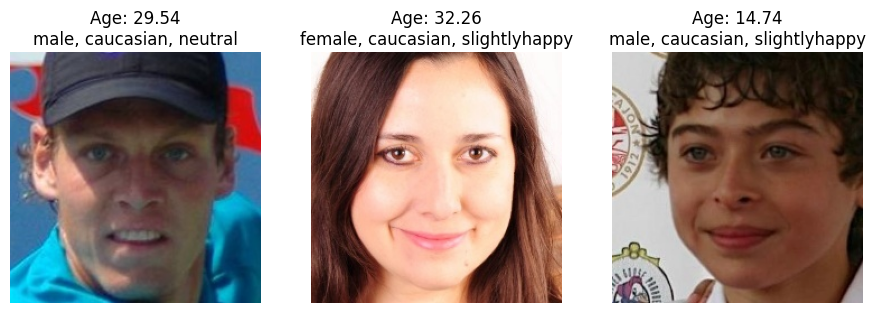

In [ ]:
import random

# Function to display image samples
def display_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(11, 5))
    for i in range(num_samples):
        random_index = random.randint(0, len(dataset) - 1)
        image, age, metadata = dataset[random_index]

        image = image * np.array([0.5]) + np.array([0.5])  # Denormalize
        image = image.permute(1, 2, 0).numpy() if isinstance(image, torch.Tensor) else np.array(image)

        axes[i].imshow(image)
        axes[i].axis("off")
        # denormalizing the age values to plot the original labels
        axes[i].set_title(f"Age: {age*dataset.__normalization_factor__():.2f}\n{', '.join(metadata)}")
    plt.show()

display_samples(dataset_train, num_samples=3)

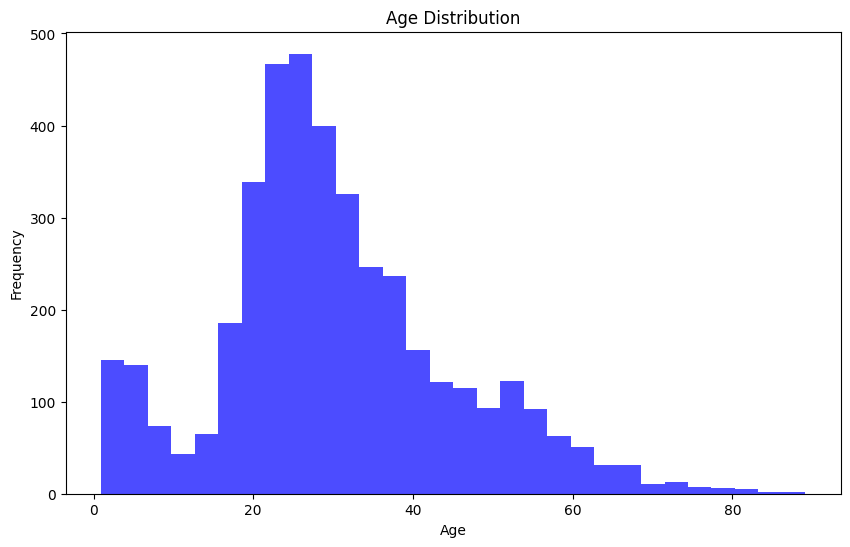

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file
df = pd.read_csv("labels_metadata_train.csv")

# Plot the age distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=30, color='blue', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

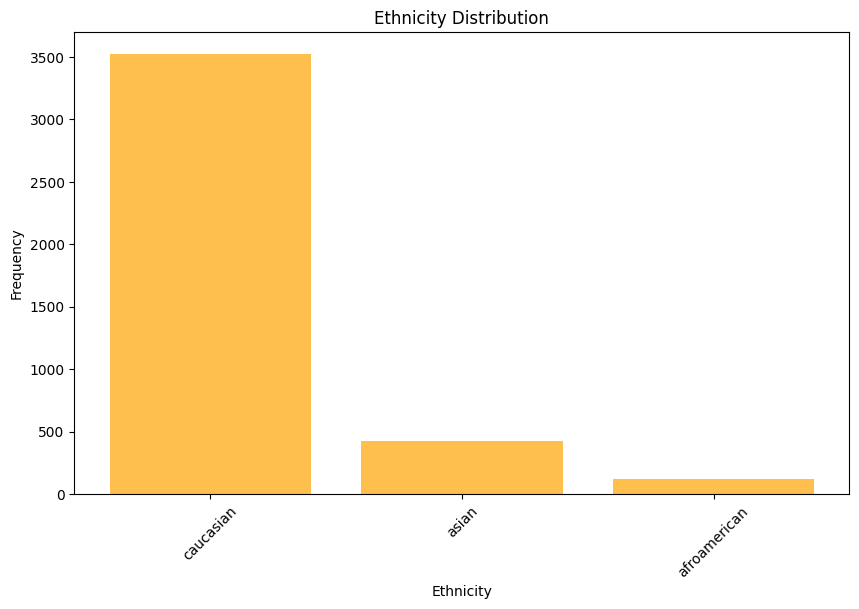

In [ ]:
# Plot the distribution of Ethnicity (as an example of metadata)
plt.figure(figsize=(10, 6))
ethnicity_valid_values = ['asian', 'caucasian', 'afroamerican']
df = df[df['ethnicity'].isin(ethnicity_valid_values)]
ethnicity_counts = df['ethnicity'].value_counts()
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='orange', alpha=0.7)
plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

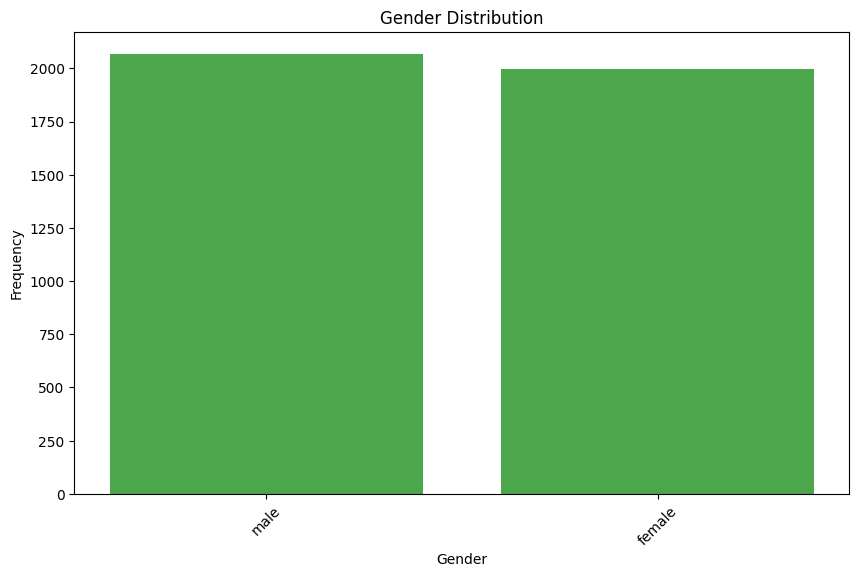

In [ ]:
# Plot the distribution of Gender (another example of metadata)
df = pd.read_csv("labels_metadata_train.csv")
plt.figure(figsize=(10, 6))
gender_valid_values = ['male', 'female']
df = df[df['gender'].isin(gender_valid_values)]
gender_counts = df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color='green', alpha=0.7)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

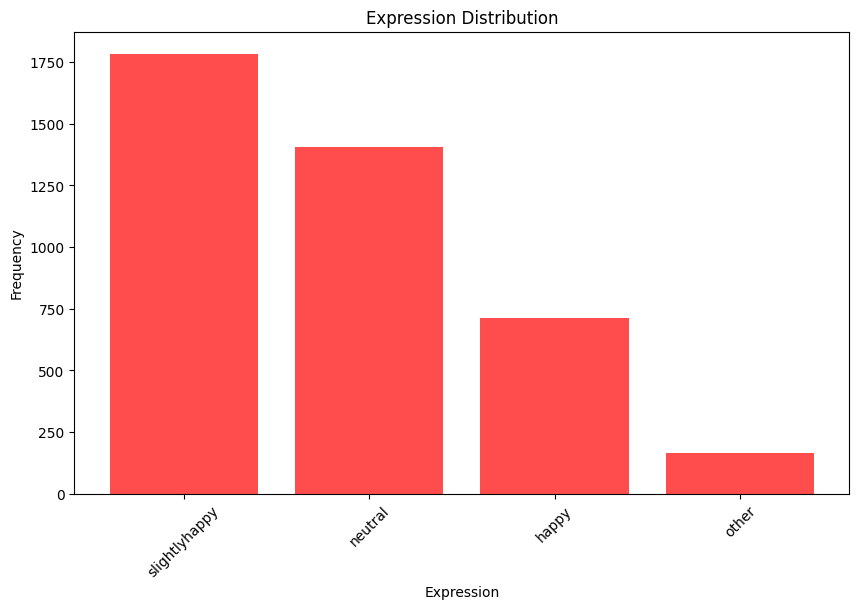

In [ ]:
# Plot the distribution of Expression (another example of metadata)
df = pd.read_csv("labels_metadata_train.csv")
plt.figure(figsize=(10, 6))
expression_valid_values = ['slightlyhappy', 'happy', 'neutral' , 'other']
df = df[df['emotion'].isin(expression_valid_values)]
expression_counts = df['emotion'].value_counts()
plt.bar(expression_counts.index, expression_counts.values, color='red', alpha=0.7)
plt.title('Expression Distribution')
plt.xlabel('Expression')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#Augmenting

In [ ]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm  # for progress bar (optional)
import torch

class AgeEstimationDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None, augmentation_transform=None):
        self.image_dir = image_dir
        self.data_info = pd.read_csv(csv_file)
        self.transform = transform
        self.augmentation_transform = augmentation_transform  # Optional augmentation transform
        self.age_normalization_factor = 100  # Used to normalize age labels

    def __len__(self):
        return len(self.data_info)

    def __normalization_factor__(self):
        return self.age_normalization_factor

    def __getitem__(self, idx):
        image_id = f"{self.data_info.iloc[idx, 0]:06d}.jpg"  # Format image ID
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")  # Load image as RGB

        # Normalize age labels (by 100) to be between 0 and 1 (assuming 100 is the max age)
        age = float(self.data_info.iloc[idx, 1]) / self.age_normalization_factor  # Load age label
        metadata = self.data_info.iloc[idx, 2:].tolist()  # Extract metadata as list
        ethnicity = metadata[1]
        age_value = int(self.data_info.iloc[idx, 1])

        # Apply augmentation based on conditions (ethnicity or age > 60)
        if (ethnicity in ['afroamerican', 'asian']) or (age_value > 60):
            if self.augmentation_transform:
                image = self.augmentation_transform(image)

        # Apply any additional transforms (like normalization)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32), metadata


def save_augmented_images_and_update_csv(dataset, augmentation_transforms, output_dir, csv_file, num_augmented_images=3):
    # Create a new directory for augmented images
    os.makedirs(output_dir, exist_ok=True)

    # Load the original CSV
    df = pd.read_csv(csv_file)


    # Augment and save images
    augmented_data = []
    for idx in tqdm(range(len(dataset)), desc="Processing images"):
        image, age, metadata = dataset[idx]  # Get the original image and other data
        original_image_id = dataset.data_info.iloc[idx, 0]
        metadata = dataset.data_info.iloc[idx, 2:].tolist()
        gender = metadata[0]
        ethnicity = metadata[1]
        expression = metadata[2]
        age_value = int(dataset.data_info.iloc[idx, 1])

        # Apply augmentation only if the condition is met (ethnicity or age > 60)
        if (ethnicity in ['afroamerican', 'asian']) or (age_value > 60):
            # Apply augmentation multiple times (num_augmented_images times)
            for i in range(num_augmented_images):
                augmented_image = augmentation_transforms(image)  # Apply the augmentation

                augmented_image_pil = transforms.ToPILImage()(augmented_image)

                # Save the augmented image
                augmented_image_name = f"augmented_{original_image_id}_{i}.jpg"
                new_image_path = os.path.join(output_dir, augmented_image_name)
                augmented_image_pil.save(new_image_path)

                # Add new entry to augmented data
                #augmented_data.append([original_image_id, age.item()] + [metadata] + [new_image_path])
                augmented_data.append([original_image_id, age.item()*100, gender, ethnicity, expression])


    # Append the augmented data to the original dataframe
    augmented_df = pd.DataFrame(augmented_data, columns=df.columns.tolist())

    # Append to the original CSV file without overwriting it
    if not os.path.exists(csv_file):
        df = pd.concat([df, augmented_df], ignore_index=True)
        df.to_csv(csv_file, index=False)
    else:
        # If file exists, append to a new file to avoid overwriting
        new_csv_file = f"augmented_{os.path.basename(csv_file)}"
        df = pd.concat([df, augmented_df], ignore_index=True)
        df.to_csv(new_csv_file, index=False)
        print(f"CSV file already exists. Augmented data saved to new file: {new_csv_file}")

    print(f"CSV file updated with augmented images: {csv_file}")


# Define the augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
])

# Define the standard transforms for all data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

# Assume the original dataset and transform
dataset_train = AgeEstimationDataset(
    image_dir="train_data",  # Directory where original images are stored
    csv_file="labels_metadata_train.csv",  # Original CSV file
    transform=data_transforms['train'],  # You can apply the transforms to training data here
    augmentation_transform=None  # Augmentation transform will be applied conditionally in the `__getitem__` method
)

# Directory to save augmented images
output_dir = "augmented_train_data"

# Number of augmented images to generate per original image
num_augmented_images = 3  # For example, generate 3 augmented images for each original image

# Update CSV with augmented images
save_augmented_images_and_update_csv(dataset_train, augmentation_transforms, output_dir, "labels_metadata_train.csv", num_augmented_images)


Processing images: 100%|██████████| 4065/4065 [00:25<00:00, 160.34it/s]

CSV file already exists. Augmented data saved to new file: augmented_labels_metadata_train.csv
CSV file updated with augmented images: labels_metadata_train.csv


In [ ]:
# Create dataset and dataloader (train set):
aug_dataset_train = AgeEstimationDataset("train_data", "augmented_labels_metadata_train.csv", transform=data_transforms['train'])
aug_dataloader_train = DataLoader(aug_dataset_train, batch_size=32, shuffle=True, num_workers=2)
print(f"Total number of train samples: {len(aug_dataloader_train.dataset)}")

# Create dataset and dataloader (validation set):
dataset_valid = AgeEstimationDataset("valid_data", "labels_metadata_valid.csv", transform=data_transforms['val'])
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True, num_workers=2)
print(f"Total number of valid samples: {len(dataloader_valid.dataset)}")

Total number of train samples: 6054
Total number of valid samples: 1482


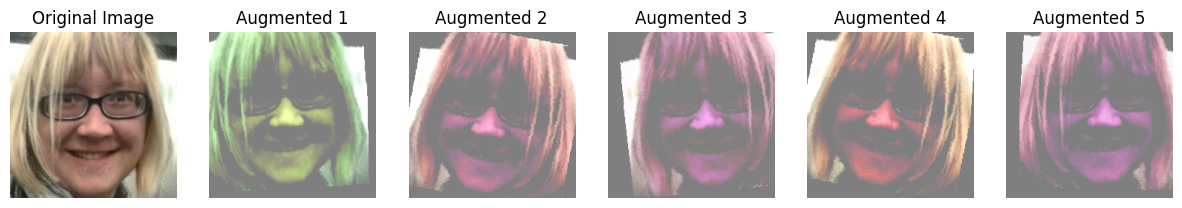

In [ ]:
import random

# Function to denormalize images for visualization
def denormalize(tensor):
    mean = [0.5]
    std = [0.5]
    tensor = tensor * std[0] + mean[0]
    tensor = tensor.clip(0, 1)
    return tensor

# Select a random sample from the dataset
random_idx = random.randint(0, len(dataset_train) - 1)
image, _, _ = dataset_train[random_idx]  # Get the image at the random index

# Apply the augmentation transforms to the image
augmented_images = []
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
])

# Generate augmented versions of the random image
for _ in range(5):  # Generate 5 augmented versions
    augmented_image = augmentation_transforms(image)  # Apply the augmentations
    augmented_images.append(augmented_image)

# Convert image tensors to numpy arrays for plotting
image = denormalize(image).numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
augmented_images = [denormalize(img).numpy().transpose(1, 2, 0) for img in augmented_images]

# Plot the original image and its augmented versions
plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, 6, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

# Plot the augmented images
for i in range(5):
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_images[i])
    plt.axis('off')
    plt.title(f'Augmented {i+1}')

plt.show()


In [ ]:
def display_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image, age, metadata = dataset[i]  # Get the image and metadata
        image = image.numpy().transpose((1, 2, 0))  # Convert tensor to numpy array (H, W, C)

        # Denormalize the image (assuming the original image was normalized between -1 and 1)
        image = image * np.array([0.5]) + np.array([0.5])  # Denormalize

        axes[i].imshow(image)
        axes[i].axis("off")

        # Ensure metadata is properly converted to strings
        metadata_str = [str(m) for m in metadata]  # Convert all metadata to strings

        # Display age and metadata
        axes[i].set_title(f"Age: {age * dataset.__normalization_factor__():.2f}\n{', '.join(metadata_str)}")

    plt.show()


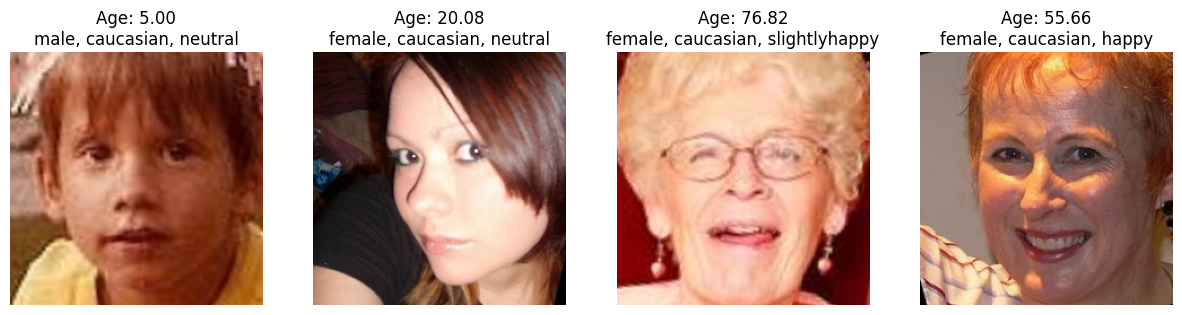

In [ ]:
display_samples(aug_dataset_train, num_samples=4)

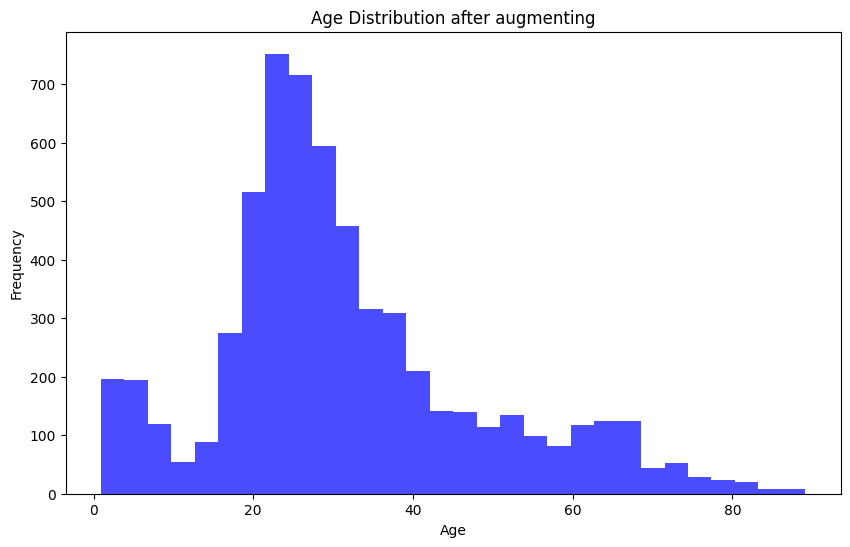

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file
df = pd.read_csv("augmented_labels_metadata_train.csv")

# Plot the age distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=30, color='blue', alpha=0.7)
plt.title('Age Distribution after augmenting')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

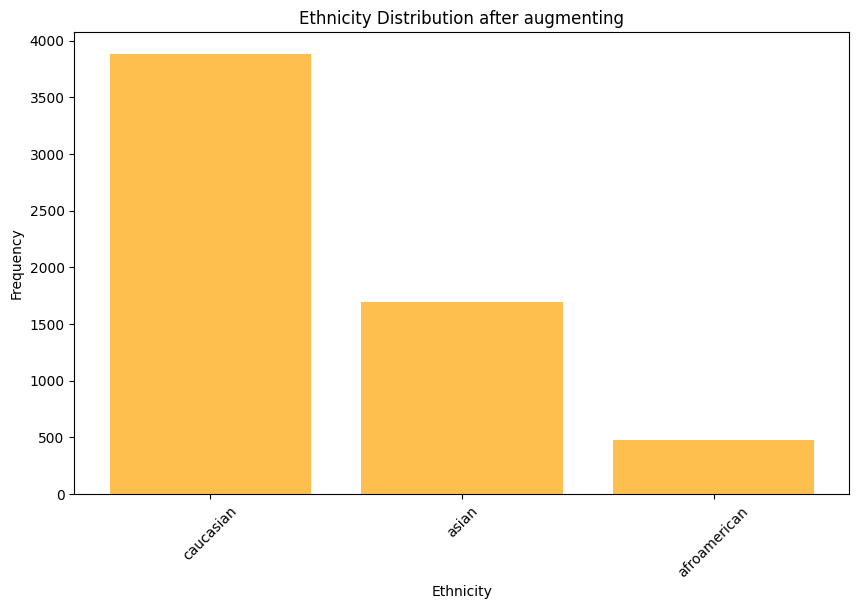

In [ ]:
# Plot the distribution of Ethnicity (as an example of metadata)
plt.figure(figsize=(10, 6))
ethnicity_valid_values = ['asian', 'caucasian', 'afroamerican']
df = df[df['ethnicity'].isin(ethnicity_valid_values)]
ethnicity_counts = df['ethnicity'].value_counts()
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='orange', alpha=0.7)
plt.title('Ethnicity Distribution after augmenting')
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

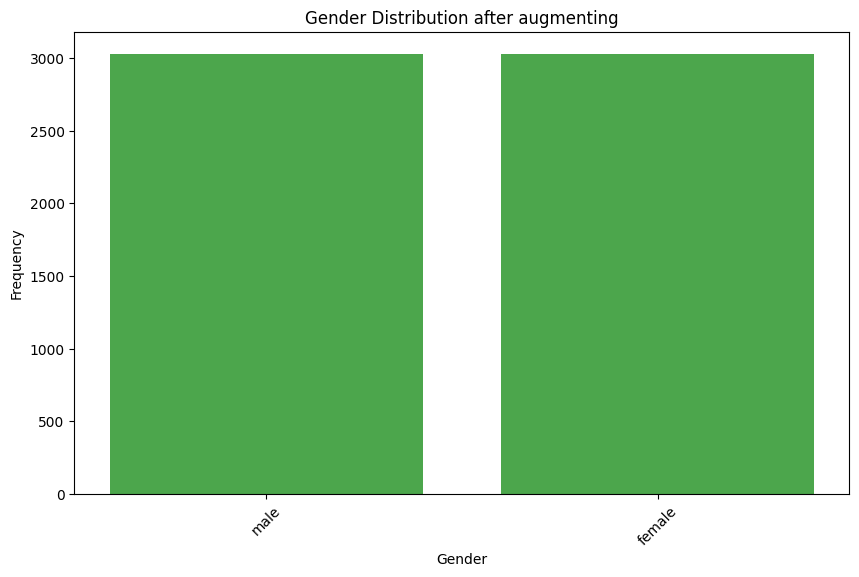

In [ ]:
# Plot the distribution of gender (as an example of metadata)
df = pd.read_csv("augmented_labels_metadata_train.csv")

plt.figure(figsize=(10, 6))
gender_valid_values = ['female', 'male']
df = df[df['gender'].isin(gender_valid_values)]
gender_counts = df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color='green', alpha=0.7)
plt.title('Gender Distribution after augmenting')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

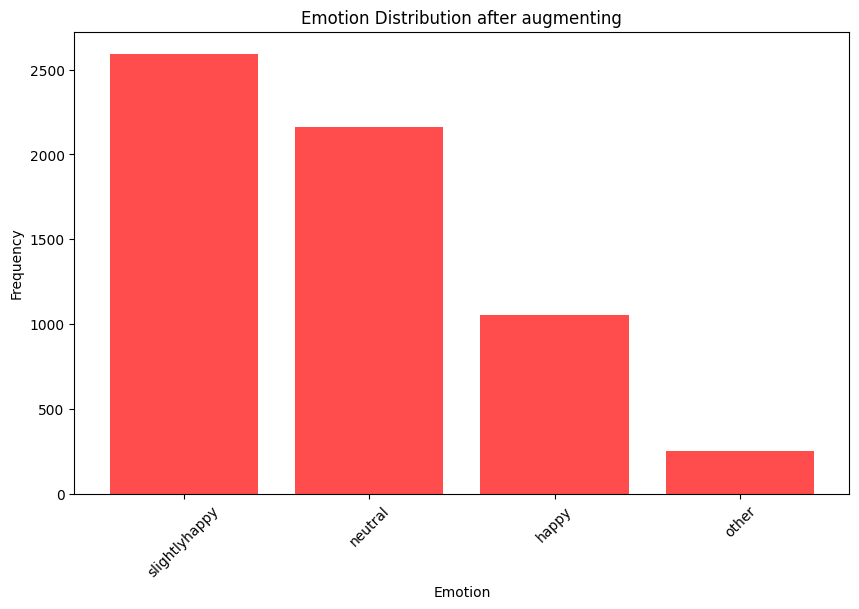

In [ ]:
# Plot the distribution of emotion (as an example of metadata)
plt.figure(figsize=(10, 6))
emotion_valid_values = ['slightlyhappy', 'happy', 'neutral', 'other']
df = df[df['emotion'].isin(emotion_valid_values)]
emotion_counts = df['emotion'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values, color='red', alpha=0.7)
plt.title('Emotion Distribution after augmenting')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Vision Transformer Model for Age Prediction (pretrained on ImageNet)
# https://pytorch.org/vision/main/models/vision_transformer.html
# https://huggingface.co/docs/transformers/main/en//model_doc/vit
class AgeEstimationViT(nn.Module):
    def __init__(self):
        super(AgeEstimationViT, self).__init__()
        self.vit = create_model("vit_base_patch16_224", pretrained=True, num_classes=0) #remove classifier head

        in_features = self.vit.num_features

        #regression head
        self.regressor = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.vit.forward_features(x) #image passed through model to extract features
        x = x[:,0] #first token (represents whole image) is selected
        x = self.regressor(x) #this token is passed through regression head which processes the features and returns age prediction
        return x

In [ ]:
# creating the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgeEstimationViT().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# print model summary
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))  # Adjust based on your model

Layer (type:depth-idx)                        Output Shape              Param #
AgeEstimationViT                              [1, 1]                    --
├─VisionTransformer: 1-1                      --                        152,064
│    └─PatchEmbed: 2-1                        [1, 196, 768]             --
│    │    └─Conv2d: 3-1                       [1, 768, 14, 14]          590,592
│    │    └─Identity: 3-2                     [1, 196, 768]             --
│    └─Dropout: 2-2                           [1, 197, 768]             --
│    └─Identity: 2-3                          [1, 197, 768]             --
│    └─Identity: 2-4                          [1, 197, 768]             --
│    └─Sequential: 2-5                        [1, 197, 768]             --
│    │    └─Block: 3-3                        [1, 197, 768]             7,087,872
│    │    └─Block: 3-4                        [1, 197, 768]             7,087,872
│    │    └─Block: 3-5                        [1, 197, 768]            

In [ ]:
# Function to plot training curves
def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

### Defining the training function

In [ ]:
# Training function with early stopping and model saving
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, patience, model_path):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    early_stopping_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            with tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}") as t:
                for inputs, labels, _ in t:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs.view_as(labels), labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    t.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.6f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                scheduler.step(epoch_loss)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                    # Save best model during training
                    print("saving best model...")
                    torch.save(best_model_wts, model_path)
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_model_wts)
                        plot_training_curves(train_losses, val_losses)
                        return model

    model.load_state_dict(best_model_wts)
    plot_training_curves(train_losses, val_losses)
    return model

# Train the model

Epoch 1/10


Train Epoch 1: 100%|██████████| 190/190 [01:24<00:00,  2.26it/s, loss=0.0027]


train Loss: 0.006541


Val Epoch 1: 100%|██████████| 47/47 [00:07<00:00,  6.23it/s, loss=0.00376]


val Loss: 0.002885
saving best model...
Epoch 2/10


Train Epoch 2: 100%|██████████| 190/190 [01:25<00:00,  2.21it/s, loss=0.00249]


train Loss: 0.001948


Val Epoch 2: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s, loss=0.00567]


val Loss: 0.002895
Epoch 3/10


Train Epoch 3: 100%|██████████| 190/190 [01:27<00:00,  2.18it/s, loss=0.00076]


train Loss: 0.001302


Val Epoch 3: 100%|██████████| 47/47 [00:07<00:00,  6.00it/s, loss=0.0038]


val Loss: 0.002351
saving best model...
Epoch 4/10


Train Epoch 4: 100%|██████████| 190/190 [01:27<00:00,  2.17it/s, loss=0.000543]


train Loss: 0.000994


Val Epoch 4: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, loss=0.00323]


val Loss: 0.002315
saving best model...
Epoch 5/10


Train Epoch 5: 100%|██████████| 190/190 [01:27<00:00,  2.16it/s, loss=0.000918]


train Loss: 0.000772


Val Epoch 5: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, loss=0.00192]


val Loss: 0.002145
saving best model...
Epoch 6/10


Train Epoch 6: 100%|██████████| 190/190 [01:27<00:00,  2.16it/s, loss=0.00027]


train Loss: 0.000699


Val Epoch 6: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=0.00266]


val Loss: 0.002151
Epoch 7/10


Train Epoch 7: 100%|██████████| 190/190 [01:27<00:00,  2.16it/s, loss=0.000324]


train Loss: 0.000647


Val Epoch 7: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=0.00111]


val Loss: 0.002121
saving best model...
Epoch 8/10


Train Epoch 8: 100%|██████████| 190/190 [01:27<00:00,  2.16it/s, loss=0.00046]


train Loss: 0.000599


Val Epoch 8: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, loss=0.000368]


val Loss: 0.002130
Epoch 9/10


Train Epoch 9: 100%|██████████| 190/190 [01:27<00:00,  2.16it/s, loss=0.000807]


train Loss: 0.000522


Val Epoch 9: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=0.00177]


val Loss: 0.002103
saving best model...
Epoch 10/10


Train Epoch 10: 100%|██████████| 190/190 [01:27<00:00,  2.16it/s, loss=0.000185]


train Loss: 0.000520


Val Epoch 10: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=0.00124]


val Loss: 0.002195


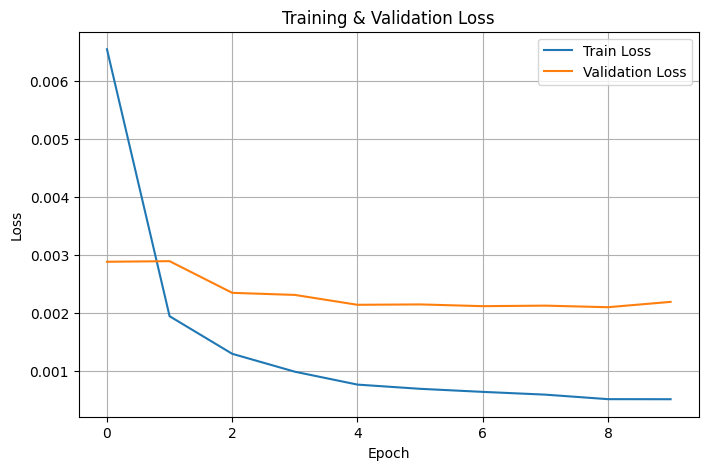

In [ ]:
#==================
MODEL_TRAIN = True
#==================

# model hyperparameters
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2)
num_epochs = 10
patience = 10

# data loaders
dataloaders = {"train": aug_dataloader_train, "val": dataloader_valid}  # Assuming split dataset

if (MODEL_TRAIN):
  #if(MOUNT_GOOGLE_DRIVE):
    #best_model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, patience,"/content/best_age_estimation_model.pth")
  best_model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, patience,"best_age_estimation_model.pth")
else:
  # download the pretrained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2025/best_age_estimation_model.zip

  # decompressing the data
  from zipfile import ZipFile

  with ZipFile('best_age_estimation_model.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')

  # removing the .zip file after extraction to clean space
  !rm best_age_estimation_model.zip


# Making predictions on Validation set


In [ ]:
# Function to make predictions on test set and compute MSE
def predict_and_evaluate(model_path, test_dataset, batch_size=32, output_csv="predictions.csv", output_zip="predictionsViTbaseline.zip"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AgeEstimationViT().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    predictions = []
    actual_ages = []
    metadatas = []

    with torch.no_grad():
        for images, labels, metadata in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)
            outputs = model(images).squeeze().cpu().numpy()
            labels = labels.cpu().numpy()

            predictions.extend(outputs*test_dataset.__normalization_factor__())
            actual_ages.extend(labels*test_dataset.__normalization_factor__())

        for idx in tqdm(range(len(test_dataset))):
            image, age, metadata = test_dataset[idx]
            metadata = test_dataset.data_info.iloc[idx, 2:].tolist()
            metadatas.append(metadata)

    mae = np.mean(np.abs(np.array(predictions) - np.array(actual_ages)))
    print(f"\n=======\nMean Absolute Error on Test Set: {mae:.4f}")

    # Save only predictions to CSV without headers
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        for pred in predictions:
            writer.writerow([pred])

    # Zip the CSV file using ZipFile
    with ZipFile(output_zip, 'w') as zipf:
        zipf.write(output_csv, os.path.basename(output_csv))

    print(f"Predictions saved to {output_csv} and compressed as {output_zip}")

    return predictions, actual_ages, mae, metadatas

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

--2025-03-26 11:06:06--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4355 (4.3K) [application/octet-stream]
Saving to: ‘bias_functions.py’

bias_functions.py   100%[===================>]   4.25K  --.-KB/s    in 0s      

2025-03-26 11:06:07 (736 MB/s) - ‘bias_functions.py’ saved [4355/4355]



In [ ]:
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

def calculate_bias(model, dataset, predictions, actual_ages, metadata):
    # Calculate bias scores
    age_bias(predictions, actual_ages)
    gender_bias(predictions, actual_ages, metadata)
    ethnicity_bias(predictions, actual_ages, metadata)
    face_expression_bias(predictions, actual_ages, metadata)

In [ ]:
dataset_valid = AgeEstimationDataset("valid_data", "labels_metadata_valid.csv", transform=data_transforms)

In [ ]:
predictions_val, actual_ages_val, mae_val, metadata_val = predict_and_evaluate("/content/best_age_estimation_model.pth", dataset_valid)


100%|██████████| 1482/1482 [00:02<00:00, 579.08it/s]


Mean Absolute Error on Test Set: 3.2565
Predictions saved to predictions.csv and compressed as predictionsViTbaseline.zip


In [ ]:
calculate_bias("/content/best_age_estimation_model.pth", dataset_valid, predictions_val, actual_ages_val, metadata_val)

Age analysis:
Size group 1 = 305, MAE = 2.663737
Size group 2 = 841, MAE = 3.068043
Size group 3 = 275, MAE = 4.068938
Size group 4 = 61, MAE = 5.156112
---------
Age bias (Ba) =  1.4130031
Gender analysis:
Size group female = 716, MAE = 3.464458
Size group male = 766, MAE = 3.062132
---------
Gender bias (Bg) =  0.40232587
Ethnicity Analysis:
Size group asian = 116, MAE = 3.225081
Size group afroamerican = 50, MAE = 3.014924
Size group caucasian = 1316, MAE = 3.268457
---------
Ethnicity bias (Be) =  0.1690216
Face experession Analysis:
Size group happy = 403, MAE = 3.609001
Size group slightlyhappy = 476, MAE = 3.201524
Size group neutral = 492, MAE = 2.983061
Size group other = 111, MAE = 3.424558
---------
Face Expression bias (Bf) =  0.35014233


# Making predictions on Test set
The following cells are generating predictions (and evaluating them) on the **Test set** so that we can create our submission file to be uploaded to our age estimation challenge. **IMPORTANT:** <font color='red'>**Do not evaluate your model on the Test set when defining your training strategy, model or hyperparameters.</font> For this, use the Validation set.**

In [ ]:
# Create dataset and dataloader (test set):
dataset_test = AgeEstimationDataset("test_data", "labels_metadata_test.csv", transform=data_transforms)


In [ ]:
predictions, actual_ages, mae, metadata = predict_and_evaluate("/content/best_age_estimation_model.pth", dataset_test)


100%|██████████| 1978/1978 [00:02<00:00, 684.44it/s]


Mean Absolute Error on Test Set: 3.8384
Predictions saved to predictions.csv and compressed as predictionsViTbaseline.zip


In [ ]:
calculate_bias("/content/best_age_estimation_model.pth", dataset_test, predictions, actual_ages, metadata)

Age analysis:
Size group 1 = 369, MAE = 2.927843
Size group 2 = 1044, MAE = 3.328421
Size group 3 = 390, MAE = 4.671937
Size group 4 = 175, MAE = 6.943423
---------
Age bias (Ba) =  2.2317095
Gender analysis:
Size group female = 1020, MAE = 3.960292
Size group male = 958, MAE = 3.708666
---------
Gender bias (Bg) =  0.2516253
Ethnicity Analysis:
Size group asian = 129, MAE = 3.690432
Size group afroamerican = 56, MAE = 3.790375
Size group caucasian = 1793, MAE = 3.850571
---------
Ethnicity bias (Be) =  0.10675939
Face experession Analysis:
Size group happy = 589, MAE = 3.905204
Size group slightlyhappy = 505, MAE = 3.941454
Size group neutral = 756, MAE = 3.716886
Size group other = 128, MAE = 3.842461
---------
Face Expression bias (Bf) =  0.1227415


#Custom Loss (non-augmented data)

In [ ]:
class AgeEstimationDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.data_info = pd.read_csv(csv_file)
        self.transform = transform
        self.age_normalization_factor = 100; # used to normalize age labels

    def __len__(self):
        return len(self.data_info)

    def __normalization_factor__(self):
        return self.age_normalization_factor

    def __getitem__(self, idx):
        image_id = f"{self.data_info.iloc[idx, 0]:06d}.jpg"  # Format image ID
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")  # Load image as RGB

        # normalizing age labes (by 100) to be between 0 and 1 (assuming 100 is the max age)
        age = float(self.data_info.iloc[idx, 1])/self.age_normalization_factor  # Load age label
        metadata = self.data_info.iloc[idx, 2:].tolist()  # Extract metadata as list
        ethnicity = self.data_info.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32), metadata

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
# Create dataset and dataloader (train set):
dataset_train = AgeEstimationDataset("train_data", "labels_metadata_train.csv", transform=data_transforms)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)
print(f"Total number of train samples: {len(dataloader_train.dataset)}")

# Create dataset and dataloader (validation set):
dataset_valid = AgeEstimationDataset("valid_data", "labels_metadata_valid.csv", transform=data_transforms)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True, num_workers=2)
print(f"Total number of valid samples: {len(dataloader_valid.dataset)}")

Total number of train samples: 4065
Total number of valid samples: 1482


In [ ]:
df = pd.read_csv("labels_metadata_train.csv")
print(df['ethnicity'].value_counts())  # Check the distribution of ethnicity in the original dataset
print(df['gender'].value_counts())
print(df['emotion'].value_counts())
over_60_count = df[df['age'] > 60].shape[0]
print(f"Number of people over 60: {over_60_count}")

ethnicity
caucasian       3522
asian            424
afroamerican     119
Name: count, dtype: int64
gender
male      2068
female    1997
Name: count, dtype: int64
emotion
slightlyhappy    1784
neutral          1404
happy             712
other             165
Name: count, dtype: int64
Number of people over 60: 148


In [ ]:
group_counts = {'caucasian' : 3522, 'asian' : 424, 'afroamerican' : 119, 'male' : 2068, 'female' : 1997, 'slightlyhappy' : 1784, 'neutral' : 1404, 'happy' : 712, 'other' : 165}
#group_labels = ['caucasian','asian', 'afroamerican', 'male', 'female', 'slightlyhappy', 'neutral', 'happy', 'other']

def customized_mse_loss_batch(y_true, y_pred, group_counts, metadata):
    """
    Customized MSE loss that assigns higher weight to underrepresented groups.

    Parameters:
    - y_true: Tensor of true values (e.g., true ages) of shape (batch_size,)
    - y_pred: Tensor of predicted values (e.g., predicted ages) of shape (batch_size,)
    - group_labels: Tensor or list of group labels corresponding to each sample in the batch
    - group_counts: Dictionary with counts of each group in the entire dataset

    Returns:
    - Weighted MSE loss for the batch
    """
    # Convert to float if necessary
    y_true = y_true.float()
    y_pred = y_pred.float()

    # Compute the Mean Squared Error (MSE) loss for each sample
    mse_loss = (y_pred - y_true) ** 2

    # Create a weight vector based on the group frequencies (inverse frequency weighting)
    # give higher weights to underrepresented groups
    group_weights = []
    #for label in group_labels:
    for i in range(len(metadata[0])):
        label = metadata[1][i]
        group_size = group_counts.get(label, 1)  # Use 1 to avoid division by zero
        group_weight = 1 / group_size  # Inverse of the frequency (lower frequency -> higher weight)
        group_weights.append(group_weight)

    # Convert group_weights to a tensor
    weight_vec = torch.tensor(group_weights, dtype=torch.float32, device = y_true.device)

    # Apply the weight to the MSE loss
    weighted_mse_loss = mse_loss * weight_vec

    # Return the mean of the weighted loss
    return weighted_mse_loss.mean()

In [ ]:
#train model with custom loss that accounts for both age and ethnicity weights
def train_model_with_custom_loss(model, dataloaders, optimizer, scheduler, num_epochs, patience, model_path):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    early_stopping_counter = 0
    train_losses = []
    val_losses = []
    epoch_threshold = 3
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            with tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}") as t:

                for inputs, labels, metadata in t:
                    inputs, labels = inputs.to(device), labels.to(device)
                    genders = metadata[0]
                    ethnicities = metadata[1]
                    expressions = metadata[2]

                    optimizer.zero_grad()

                    if isinstance(ethnicities, tuple):
                        ethnicities = list(ethnicities)

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)

                        # Calculate sample weights based on age and ethnicity
                        #sample_weights = calculate_sample_weights(labels.cpu().detach().numpy(), ethnicities, expressions, genders, 4)

                        #print(f'Sample Weights: {sample_weights}')

                        #sample_weights = torch.tensor(sample_weights, dtype=torch.float32, device=inputs.device)

                        # Calculate weighted MSE loss
                        loss = customized_mse_loss_batch(labels, outputs.view_as(labels), group_counts, metadata)
                        #loss = weighted_mse_loss(outputs.view_as(labels), labels, sample_weights)
                        # Apply custom loss starting from a certain epoch

                        '''if epoch > epoch_threshold:
                            # Custom loss applied after epoch_threshold
                            loss = customized_mse_loss_batch(labels, outputs.view_as(labels), group_labels, group_counts)
                        else:
                            # Default loss (e.g., MSE) before epoch_threshold
                            loss = criterion(outputs.view_as(labels), labels)'''

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    t.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.6f}')


            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                scheduler.step(epoch_loss)

                # Save the best model during training
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                    print("Saving best model...")
                    torch.save(best_model_wts, model_path)
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_model_wts)
                        plot_training_curves(train_losses, val_losses)
                        return model


    print(f'Predictions: {outputs}, Labels: {labels}')
    # Load best model weights and plot training curves
    model.load_state_dict(best_model_wts)
    plot_training_curves(train_losses, val_losses)
    return model


Epoch 1/10


Train Epoch 1: 100%|██████████| 128/128 [00:56<00:00,  2.25it/s, loss=9.38e-7]


train Loss: 0.000000


Val Epoch 1: 100%|██████████| 47/47 [00:07<00:00,  6.16it/s, loss=3.21e-6]


val Loss: 0.000002
Saving best model...
Epoch 2/10


Train Epoch 2: 100%|██████████| 128/128 [00:57<00:00,  2.21it/s, loss=1.82e-8]


train Loss: 0.000001


Val Epoch 2: 100%|██████████| 47/47 [00:07<00:00,  6.07it/s, loss=6.66e-6]


val Loss: 0.000002
Epoch 3/10


Train Epoch 3: 100%|██████████| 128/128 [00:58<00:00,  2.19it/s, loss=5.14e-7]


train Loss: 0.000001


Val Epoch 3: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, loss=1.77e-6]


val Loss: 0.000001
Saving best model...
Epoch 4/10


Train Epoch 4: 100%|██████████| 128/128 [00:58<00:00,  2.18it/s, loss=9.74e-8]


train Loss: 0.000001


Val Epoch 4: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, loss=7.04e-7]


val Loss: 0.000002
Epoch 5/10


Train Epoch 5: 100%|██████████| 128/128 [00:58<00:00,  2.17it/s, loss=3.02e-5]


train Loss: 0.000001


Val Epoch 5: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=2.43e-6]


val Loss: 0.000002
Epoch 6/10


Train Epoch 6: 100%|██████████| 128/128 [00:59<00:00,  2.17it/s, loss=1.73e-6]


train Loss: 0.000001


Val Epoch 6: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=6.12e-6]


val Loss: 0.000002
Epoch 7/10


Train Epoch 7: 100%|██████████| 128/128 [00:59<00:00,  2.16it/s, loss=2.84e-8]


train Loss: 0.000001


Val Epoch 7: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=9.82e-7]


val Loss: 0.000002
Epoch 8/10


Train Epoch 8: 100%|██████████| 128/128 [00:59<00:00,  2.16it/s, loss=5.2e-8]


train Loss: 0.000001


Val Epoch 8: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, loss=1.54e-6]


val Loss: 0.000001
Epoch 9/10


Train Epoch 9: 100%|██████████| 128/128 [00:59<00:00,  2.16it/s, loss=4.05e-7]


train Loss: 0.000000


Val Epoch 9: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, loss=1.12e-6]


val Loss: 0.000002
Epoch 10/10


Train Epoch 10: 100%|██████████| 128/128 [00:59<00:00,  2.16it/s, loss=1.87e-7]


train Loss: 0.000000


Val Epoch 10: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, loss=1.5e-7]


val Loss: 0.000002
Predictions: tensor([[0.0294],
        [0.0560],
        [0.2622],
        [0.4566],
        [0.3246],
        [0.4482],
        [0.0226],
        [0.2620],
        [0.3839],
        [0.2056]], device='cuda:0'), Labels: tensor([0.0190, 0.0655, 0.2529, 0.4648, 0.2753, 0.4708, 0.0218, 0.2531, 0.4275,
        0.2023], device='cuda:0')


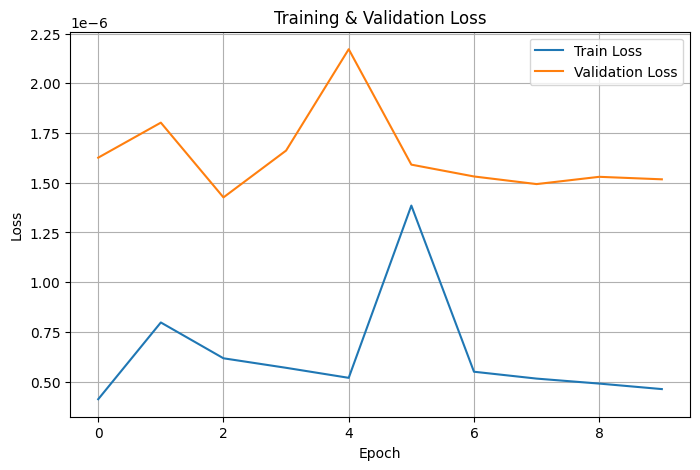

In [ ]:
#==================
MODEL_TRAIN = True
#==================

# model hyperparameters
#criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2)
num_epochs =10
patience = 10

# data loaders
dataloaders = {"train": dataloader_train, "val": dataloader_valid}  # Assuming split dataset

if (MODEL_TRAIN):
  #if(MOUNT_GOOGLE_DRIVE):
    #best_model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, patience,"/content/best_age_estimation_model.pth")
  best_model = train_model_with_custom_loss(model, dataloaders, optimizer, scheduler, num_epochs, patience,"best_age_estimation_model_customloss.pth")
else:
  # download the pretrained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2025/best_age_estimation_model.zip

  # decompressing the data
  from zipfile import ZipFile

  with ZipFile('best_age_estimation_model_customloss.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')

  # removing the .zip file after extraction to clean space
  !rm best_age_estimation_model.zip


# Making predictions on Validation set (w/ custom loss)

In [ ]:
dataset_valid = AgeEstimationDataset("valid_data", "labels_metadata_valid.csv", transform=data_transforms)


In [ ]:
predictions_val, actual_ages_val, mae_val, metadata_val = predict_and_evaluate("/content/best_age_estimation_model_customloss.pth", dataset_valid)
print(predictions_val)
print(actual_ages_val)

100%|██████████| 1482/1482 [00:02<00:00, 660.19it/s]


Mean Absolute Error on Test Set: 3.3608
Predictions saved to predictions.csv and compressed as predictionsViTbaseline.zip
[np.float32(27.712961), np.float32(29.29981), np.float32(24.856781), np.float32(73.32887), np.float32(22.528975), np.float32(27.084324), np.float32(33.13427), np.float32(3.6398802), np.float32(12.806414), np.float32(1.7099898), np.float32(27.835867), np.float32(45.46268), np.float32(22.954449), np.float32(36.750355), np.float32(2.5231605), np.float32(48.16519), np.float32(3.874627), np.float32(52.285458), np.float32(42.09642), np.float32(29.542776), np.float32(44.701157), np.float32(27.551067), np.float32(55.00775), np.float32(36.951508), np.float32(22.534504), np.float32(7.8173203), np.float32(32.10411), np.float32(23.517279), np.float32(3.0452647), np.float32(50.83898), np.float32(17.979961), np.float32(64.24505), np.float32(9.006515), np.float32(36.86952), np.float32(57.714714), np.float32(24.372124), np.float32(32.45317), np.float32(20.39722), np.float32(32.039

In [ ]:
calculate_bias("/content/best_age_estimation_model_customloss.pth", dataset_valid, predictions_val, actual_ages_val, metadata_val)

Age analysis:
Size group 1 = 305, MAE = 3.170687
Size group 2 = 841, MAE = 3.135940
Size group 3 = 275, MAE = 3.907117
Size group 4 = 61, MAE = 4.948283
---------
Age bias (Ba) =  1.0289103
Gender analysis:
Size group female = 716, MAE = 3.479236
Size group male = 766, MAE = 3.250070
---------
Gender bias (Bg) =  0.22916627
Ethnicity Analysis:
Size group asian = 116, MAE = 3.258102
Size group afroamerican = 50, MAE = 3.050429
Size group caucasian = 1316, MAE = 3.381630
---------
Ethnicity bias (Be) =  0.22080088
Face experession Analysis:
Size group happy = 403, MAE = 3.593610
Size group slightlyhappy = 476, MAE = 3.379297
Size group neutral = 492, MAE = 3.179236
Size group other = 111, MAE = 3.240834
---------
Face Expression bias (Bf) =  0.23026407


# Making predictions on Test set (custom loss)

In [ ]:
dataset_test = AgeEstimationDataset("test_data", "labels_metadata_test.csv", transform=data_transforms)


In [ ]:
predictions, actual_ages, mae, metadata = predict_and_evaluate("/content/best_age_estimation_model_customloss.pth", dataset_test)


100%|██████████| 1978/1978 [00:02<00:00, 663.87it/s]


Mean Absolute Error on Test Set: 3.7721
Predictions saved to predictions.csv and compressed as predictionsViTbaseline.zip


In [ ]:
calculate_bias("/content/best_age_estimation_model_customloss.pth", dataset_test, predictions, actual_ages, metadata)

Age analysis:
Size group 1 = 369, MAE = 3.279433
Size group 2 = 1044, MAE = 3.169894
Size group 3 = 390, MAE = 4.507536
Size group 4 = 175, MAE = 6.764156
---------
Age bias (Ba) =  2.0018148
Gender analysis:
Size group female = 1020, MAE = 3.864873
Size group male = 958, MAE = 3.673252
---------
Gender bias (Bg) =  0.1916213
Ethnicity Analysis:
Size group asian = 129, MAE = 3.881360
Size group afroamerican = 56, MAE = 4.138392
Size group caucasian = 1793, MAE = 3.752761
---------
Ethnicity bias (Be) =  0.25708738
Face experession Analysis:
Size group happy = 589, MAE = 3.888822
Size group slightlyhappy = 505, MAE = 3.898062
Size group neutral = 756, MAE = 3.616497
Size group other = 128, MAE = 3.656542
---------
Face Expression bias (Bf) =  0.17949569


#Custom Loss with augmented data

#Augmentating

In [ ]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm  # for progress bar (optional)
import torch

class AgeEstimationDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None, augmentation_transform=None):
        self.image_dir = image_dir
        self.data_info = pd.read_csv(csv_file)
        self.transform = transform
        self.augmentation_transform = augmentation_transform  # Optional augmentation transform
        self.age_normalization_factor = 100  # Used to normalize age labels

    def __len__(self):
        return len(self.data_info)

    def __normalization_factor__(self):
        return self.age_normalization_factor

    def __getitem__(self, idx):
        image_id = f"{self.data_info.iloc[idx, 0]:06d}.jpg"  # Format image ID
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")  # Load image as RGB

        # Normalize age labels (by 100) to be between 0 and 1 (assuming 100 is the max age)
        age = float(self.data_info.iloc[idx, 1]) / self.age_normalization_factor  # Load age label
        metadata = self.data_info.iloc[idx, 2:].tolist()  # Extract metadata as list
        ethnicity = metadata[1]
        age_value = int(self.data_info.iloc[idx, 1])

        # Apply augmentation based on conditions (ethnicity or age > 60)
        if (ethnicity in ['afroamerican', 'asian']) or (age_value > 60):
            if self.augmentation_transform:
                image = self.augmentation_transform(image)

        # Apply any additional transforms (like normalization)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32), metadata


def save_augmented_images_and_update_csv(dataset, augmentation_transforms, output_dir, csv_file, num_augmented_images=3):
    # Create a new directory for augmented images
    os.makedirs(output_dir, exist_ok=True)

    # Load the original CSV
    df = pd.read_csv(csv_file)


    # Augment and save images
    augmented_data = []
    for idx in tqdm(range(len(dataset)), desc="Processing images"):
        image, age, metadata = dataset[idx]  # Get the original image and other data
        original_image_id = dataset.data_info.iloc[idx, 0]
        metadata = dataset.data_info.iloc[idx, 2:].tolist()
        gender = metadata[0]
        ethnicity = metadata[1]
        expression = metadata[2]
        age_value = int(dataset.data_info.iloc[idx, 1])

        # Apply augmentation only if the condition is met (ethnicity or age > 60)
        if (ethnicity in ['afroamerican', 'asian']) or (age_value > 60):
            # Apply augmentation multiple times (num_augmented_images times)
            for i in range(num_augmented_images):
                augmented_image = augmentation_transforms(image)  # Apply the augmentation

                augmented_image_pil = transforms.ToPILImage()(augmented_image)

                # Save the augmented image
                augmented_image_name = f"augmented_{original_image_id}_{i}.jpg"
                new_image_path = os.path.join(output_dir, augmented_image_name)
                augmented_image_pil.save(new_image_path)

                # Add new entry to augmented data
                #augmented_data.append([original_image_id, age.item()] + [metadata] + [new_image_path])
                augmented_data.append([original_image_id, age.item()*100, gender, ethnicity, expression])


    # Append the augmented data to the original dataframe
    augmented_df = pd.DataFrame(augmented_data, columns=df.columns.tolist())

    # Append to the original CSV file without overwriting it
    if not os.path.exists(csv_file):
        df = pd.concat([df, augmented_df], ignore_index=True)
        df.to_csv(csv_file, index=False)
    else:
        # If file exists, append to a new file to avoid overwriting
        new_csv_file = f"augmented_{os.path.basename(csv_file)}"
        df = pd.concat([df, augmented_df], ignore_index=True)
        df.to_csv(new_csv_file, index=False)
        print(f"CSV file already exists. Augmented data saved to new file: {new_csv_file}")

    print(f"CSV file updated with augmented images: {csv_file}")


# Define the augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
])

# Define the standard transforms for all data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

# Assume the original dataset and transform
dataset_train = AgeEstimationDataset(
    image_dir="train_data",  # Directory where original images are stored
    csv_file="labels_metadata_train.csv",  # Original CSV file
    transform=data_transforms['train'],  # You can apply the transforms to training data here
    augmentation_transform=None  # Augmentation transform will be applied conditionally in the `__getitem__` method
)

# Directory to save augmented images
output_dir = "augmented_train_data"

# Number of augmented images to generate per original image
num_augmented_images = 3  # For example, generate 3 augmented images for each original image

# Update CSV with augmented images
save_augmented_images_and_update_csv(dataset_train, augmentation_transforms, output_dir, "labels_metadata_train.csv", num_augmented_images)


Processing images: 100%|██████████| 4065/4065 [00:24<00:00, 164.50it/s]

CSV file already exists. Augmented data saved to new file: augmented_labels_metadata_train.csv
CSV file updated with augmented images: labels_metadata_train.csv


In [ ]:
# Create dataset and dataloader (train set):
aug_dataset_train = AgeEstimationDataset("train_data", "augmented_labels_metadata_train.csv", transform=data_transforms['train'])
aug_dataloader_train = DataLoader(aug_dataset_train, batch_size=32, shuffle=True, num_workers=2)
print(f"Total number of train samples: {len(aug_dataloader_train.dataset)}")

# Create dataset and dataloader (validation set):
dataset_valid = AgeEstimationDataset("valid_data", "labels_metadata_valid.csv", transform=data_transforms['val'])
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True, num_workers=2)
print(f"Total number of valid samples: {len(dataloader_valid.dataset)}")

Total number of train samples: 6054
Total number of valid samples: 1482


Epoch 1/10


Train Epoch 1: 100%|██████████| 190/190 [01:24<00:00,  2.25it/s, loss=2.55e-6]


train Loss: 0.000001


Val Epoch 1: 100%|██████████| 47/47 [00:07<00:00,  6.15it/s, loss=5.08e-6]


val Loss: 0.000002
Saving best model...
Epoch 2/10


Train Epoch 2: 100%|██████████| 190/190 [01:26<00:00,  2.19it/s, loss=1.65e-7]


train Loss: 0.000001


Val Epoch 2: 100%|██████████| 47/47 [00:07<00:00,  6.03it/s, loss=4.26e-7]


val Loss: 0.000001
Saving best model...
Epoch 3/10


Train Epoch 3: 100%|██████████| 190/190 [01:27<00:00,  2.18it/s, loss=4.05e-7]


train Loss: 0.000001


Val Epoch 3: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=5.98e-7]


val Loss: 0.000002
Epoch 4/10


Train Epoch 4: 100%|██████████| 190/190 [01:27<00:00,  2.17it/s, loss=4.71e-7]


train Loss: 0.000001


Val Epoch 4: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, loss=7.13e-7]


val Loss: 0.000002
Epoch 5/10


Train Epoch 5: 100%|██████████| 190/190 [01:28<00:00,  2.16it/s, loss=1.02e-7]


train Loss: 0.000001


Val Epoch 5: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, loss=6.29e-7]


val Loss: 0.000002
Epoch 6/10


Train Epoch 6: 100%|██████████| 190/190 [01:28<00:00,  2.16it/s, loss=1.03e-6]


train Loss: 0.000001


Val Epoch 6: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, loss=4.57e-6]


val Loss: 0.000001
Epoch 7/10


Train Epoch 7: 100%|██████████| 190/190 [01:28<00:00,  2.15it/s, loss=1.35e-7]


train Loss: 0.000000


Val Epoch 7: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, loss=8.62e-7]


val Loss: 0.000001
Epoch 8/10


Train Epoch 8: 100%|██████████| 190/190 [01:28<00:00,  2.15it/s, loss=1.96e-7]


train Loss: 0.000000


Val Epoch 8: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, loss=4.6e-7]


val Loss: 0.000001
Epoch 9/10


Train Epoch 9: 100%|██████████| 190/190 [01:28<00:00,  2.15it/s, loss=1.12e-7]


train Loss: 0.000000


Val Epoch 9: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, loss=1.29e-6]


val Loss: 0.000001
Epoch 10/10


Train Epoch 10: 100%|██████████| 190/190 [01:28<00:00,  2.15it/s, loss=3.36e-7]


train Loss: 0.000000


Val Epoch 10: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, loss=4.02e-7]


val Loss: 0.000001
Predictions: tensor([[0.2310],
        [0.5164],
        [0.3140],
        [0.0447],
        [0.2818],
        [0.4138],
        [0.2833],
        [0.1330],
        [0.2551],
        [0.2290]], device='cuda:0'), Labels: tensor([0.2304, 0.5562, 0.2221, 0.0497, 0.2862, 0.4614, 0.2979, 0.1071, 0.2287,
        0.2138], device='cuda:0')


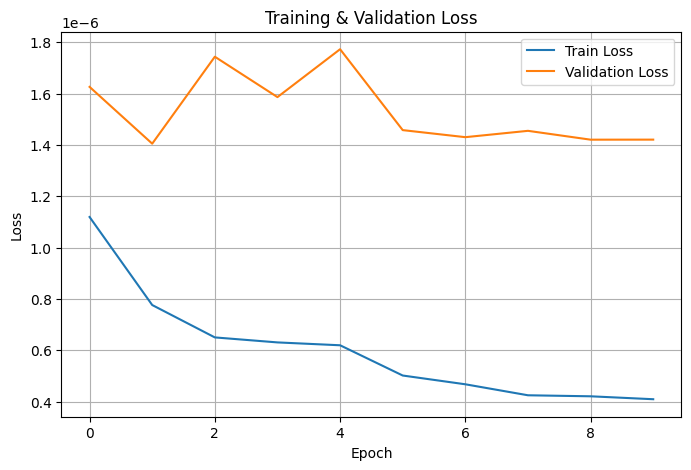

In [ ]:
#==================
MODEL_TRAIN = True
#==================

# model hyperparameters
#criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2)
num_epochs =10
patience = 10

# data loaders
dataloaders = {"train": aug_dataloader_train, "val": dataloader_valid}  # Assuming split dataset

if (MODEL_TRAIN):
  #if(MOUNT_GOOGLE_DRIVE):
    #best_model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, patience,"/content/best_age_estimation_model.pth")
  best_model = train_model_with_custom_loss(model, dataloaders, optimizer, scheduler, num_epochs, patience,"best_age_estimation_model_customloss_augmentations.pth")
else:
  # download the pretrained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2025/best_age_estimation_model.zip

  # decompressing the data
  from zipfile import ZipFile

  with ZipFile('best_age_estimation_model_customloss_augmenations.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')

  # removing the .zip file after extraction to clean space
  !rm best_age_estimation_model.zip


# Making predictions on Validation set (w/ custom loss and augmentations)

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
dataset_valid = AgeEstimationDataset("valid_data", "labels_metadata_valid.csv", transform=data_transforms)


In [ ]:
predictions_val, actual_ages_val, mae_val, metadata_val = predict_and_evaluate("/content/best_age_estimation_model_customloss_augmentations.pth", dataset_valid)
print(predictions_val)
print(actual_ages_val)

100%|██████████| 1482/1482 [00:02<00:00, 684.49it/s]


Mean Absolute Error on Test Set: 3.3562
Predictions saved to predictions.csv and compressed as predictionsViTbaseline.zip
[np.float32(27.672636), np.float32(29.725954), np.float32(23.95454), np.float32(72.81864), np.float32(23.74612), np.float32(29.314974), np.float32(36.068554), np.float32(3.7058287), np.float32(10.768637), np.float32(1.8892056), np.float32(31.801352), np.float32(48.5273), np.float32(22.747223), np.float32(39.6144), np.float32(2.5559745), np.float32(49.920006), np.float32(3.6097903), np.float32(50.469334), np.float32(43.326515), np.float32(29.711632), np.float32(44.130177), np.float32(29.348904), np.float32(53.061058), np.float32(35.776756), np.float32(22.586233), np.float32(8.2470665), np.float32(34.15822), np.float32(23.178404), np.float32(3.0623448), np.float32(52.061337), np.float32(17.980732), np.float32(64.41441), np.float32(7.1651645), np.float32(37.85124), np.float32(56.901516), np.float32(24.396063), np.float32(32.190746), np.float32(21.278284), np.float32(3

In [ ]:
calculate_bias("/content/best_age_estimation_model_customloss_augmentations.pth", dataset_valid, predictions_val, actual_ages_val, metadata_val)

Age analysis:
Size group 1 = 305, MAE = 2.993706
Size group 2 = 841, MAE = 3.193107
Size group 3 = 275, MAE = 3.879612
Size group 4 = 61, MAE = 5.058618
---------
Age bias (Ba) =  1.1468738
Gender analysis:
Size group female = 716, MAE = 3.545596
Size group male = 766, MAE = 3.179250
---------
Gender bias (Bg) =  0.36634612
Ethnicity Analysis:
Size group asian = 116, MAE = 3.157773
Size group afroamerican = 50, MAE = 3.074736
Size group caucasian = 1316, MAE = 3.384433
---------
Ethnicity bias (Be) =  0.20646508
Face experession Analysis:
Size group happy = 403, MAE = 3.750697
Size group slightlyhappy = 476, MAE = 3.339913
Size group neutral = 492, MAE = 3.057733
Size group other = 111, MAE = 3.317282
---------
Face Expression bias (Bf) =  0.35025427


# Making predictions on Test set (custom loss and augmentations)

In [ ]:
dataset_test = AgeEstimationDataset("test_data", "labels_metadata_test.csv", transform=data_transforms)


In [ ]:
predictions, actual_ages, mae, metadata = predict_and_evaluate("/content/best_age_estimation_model_customloss_augmentations.pth", dataset_test)


100%|██████████| 1978/1978 [00:02<00:00, 681.20it/s]


Mean Absolute Error on Test Set: 3.8335
Predictions saved to predictions.csv and compressed as predictionsViTbaseline.zip


In [ ]:
calculate_bias("/content/best_age_estimation_model_customloss_augmentations.pth", dataset_test, predictions, actual_ages, metadata)

Age analysis:
Size group 1 = 369, MAE = 3.147598
Size group 2 = 1044, MAE = 3.360517
Size group 3 = 390, MAE = 4.331439
Size group 4 = 175, MAE = 6.992323
---------
Age bias (Ba) =  2.084183
Gender analysis:
Size group female = 1020, MAE = 4.020100
Size group male = 958, MAE = 3.634927
---------
Gender bias (Bg) =  0.38517332
Ethnicity Analysis:
Size group asian = 129, MAE = 3.936496
Size group afroamerican = 56, MAE = 4.345886
Size group caucasian = 1793, MAE = 3.810142
---------
Ethnicity bias (Be) =  0.3571628
Face experession Analysis:
Size group happy = 589, MAE = 4.006455
Size group slightlyhappy = 505, MAE = 3.978336
Size group neutral = 756, MAE = 3.621361
Size group other = 128, MAE = 3.719929
---------
Face Expression bias (Bf) =  0.23561525
